# Forecasting Project Volatility: Utilizing Long Short Term Memory networks to forecast flow of project volatility with high accuracy

Author: @leannmendoza

Source: https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

%matplotlib inline
plt.style.use('seaborn')

In [2]:
# Redacted info for github upload for confidentiality purposes
proj_stat_detail_view = ''
project_name_specific = ''

In [3]:
#read in csv file
main_df = pd.read_csv(proj_stat_detail_view,dtype=object)
main_df.columns = [c.replace(' ', '_') for c in main_df.columns]
main_df.shape

(136921, 159)

## 1. Data Cleanup & Preprocessing
Cleaning up data to reflect one specific project (project_name_specific) for input into the forecasting model

In [4]:
#create df with only project_name_specific data
project_df = main_df[main_df.Project_Long_Name == project_name_specific]
project_df.shape

(459, 159)

In [5]:
#Picking only features we'd like to forecast - since we are predicting volatility scores we choose V scores
volatility_scores_df = project_df[["Project_Statistic_Date", "Project_Task_Closed_Est_Act_V1","Project_Task_Estimate_Change_V2","Project_Task_Date_Est_Act_V3","Project_Task_Date_Change_V4", "Project_Task_Procrastination_V5","Project_Milestone_Date_Est_Act_V6","Project_Milestone_Date_Change_V7","Project_Worklog_Entry_Actual_V8"]].copy()
volatility_scores_df[["Project_Task_Closed_Est_Act_V1","Project_Task_Estimate_Change_V2","Project_Task_Date_Est_Act_V3","Project_Task_Date_Change_V4", "Project_Task_Procrastination_V5","Project_Milestone_Date_Est_Act_V6","Project_Milestone_Date_Change_V7","Project_Worklog_Entry_Actual_V8"]] = volatility_scores_df[["Project_Task_Closed_Est_Act_V1","Project_Task_Estimate_Change_V2","Project_Task_Date_Est_Act_V3","Project_Task_Date_Change_V4", "Project_Task_Procrastination_V5","Project_Milestone_Date_Est_Act_V6","Project_Milestone_Date_Change_V7","Project_Worklog_Entry_Actual_V8"]].apply(pd.to_numeric)
volatility_scores_df[['Project_Statistic_Date']].apply(pd.to_datetime)
volatility_scores_df = volatility_scores_df.fillna(0) #fill na with 0 indicates no change from 0 
volatility_scores_df

,Project_Statistic_Date,Project_Task_Closed_Est_Act_V1,Project_Task_Estimate_Change_V2,Project_Task_Date_Est_Act_V3,Project_Task_Date_Change_V4,Project_Task_Procrastination_V5,Project_Milestone_Date_Est_Act_V6,Project_Milestone_Date_Change_V7,Project_Worklog_Entry_Actual_V8
135252,12/9/2018,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,5.166667
135253,12/8/2018,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,5.166667
135254,12/5/2018,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
135255,12/4/2018,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
135256,12/6/2018,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
135706,4/26/2019,164.966668,290.111111,542.947368,1381.231481,52.346186,0.0,0.0,33.025210
135707,3/20/2019,146.534968,547.428571,791.111111,1864.928571,67.997206,0.0,0.0,73.745098
135708,4/11/2019,205.474591,384.911392,649.862745,1878.860759,56.123032,0.0,0.0,46.878049
135709,11/6/2019,104.689073,142.659898,333226.029167,318116.063452,47.889666,0.0,0.0,24.710588


In [6]:
# Isolating single V score to predict on ex) v1
V1_df = volatility_scores_df[["Project_Statistic_Date", "Project_Task_Closed_Est_Act_V1"]]
V1_df["Project_Statistic_Date"]=pd.to_datetime(V1_df["Project_Statistic_Date"].astype(str), format='%m/%d/%Y')

V1_df = V1_df.sort_values(by="Project_Statistic_Date",ascending=True)
V1_df

/Users/l9mendoza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Project_Statistic_Date,Project_Task_Closed_Est_Act_V1
135386,2018-10-25,0.000000
135434,2018-12-03,0.000000
135255,2018-12-04,0.000000
135254,2018-12-05,0.000000
135256,2018-12-06,0.000000
...,...,...
135351,2020-02-29,104.855584
135438,2020-03-01,104.855584
135488,2020-03-02,104.855584
135352,2020-03-03,104.855584


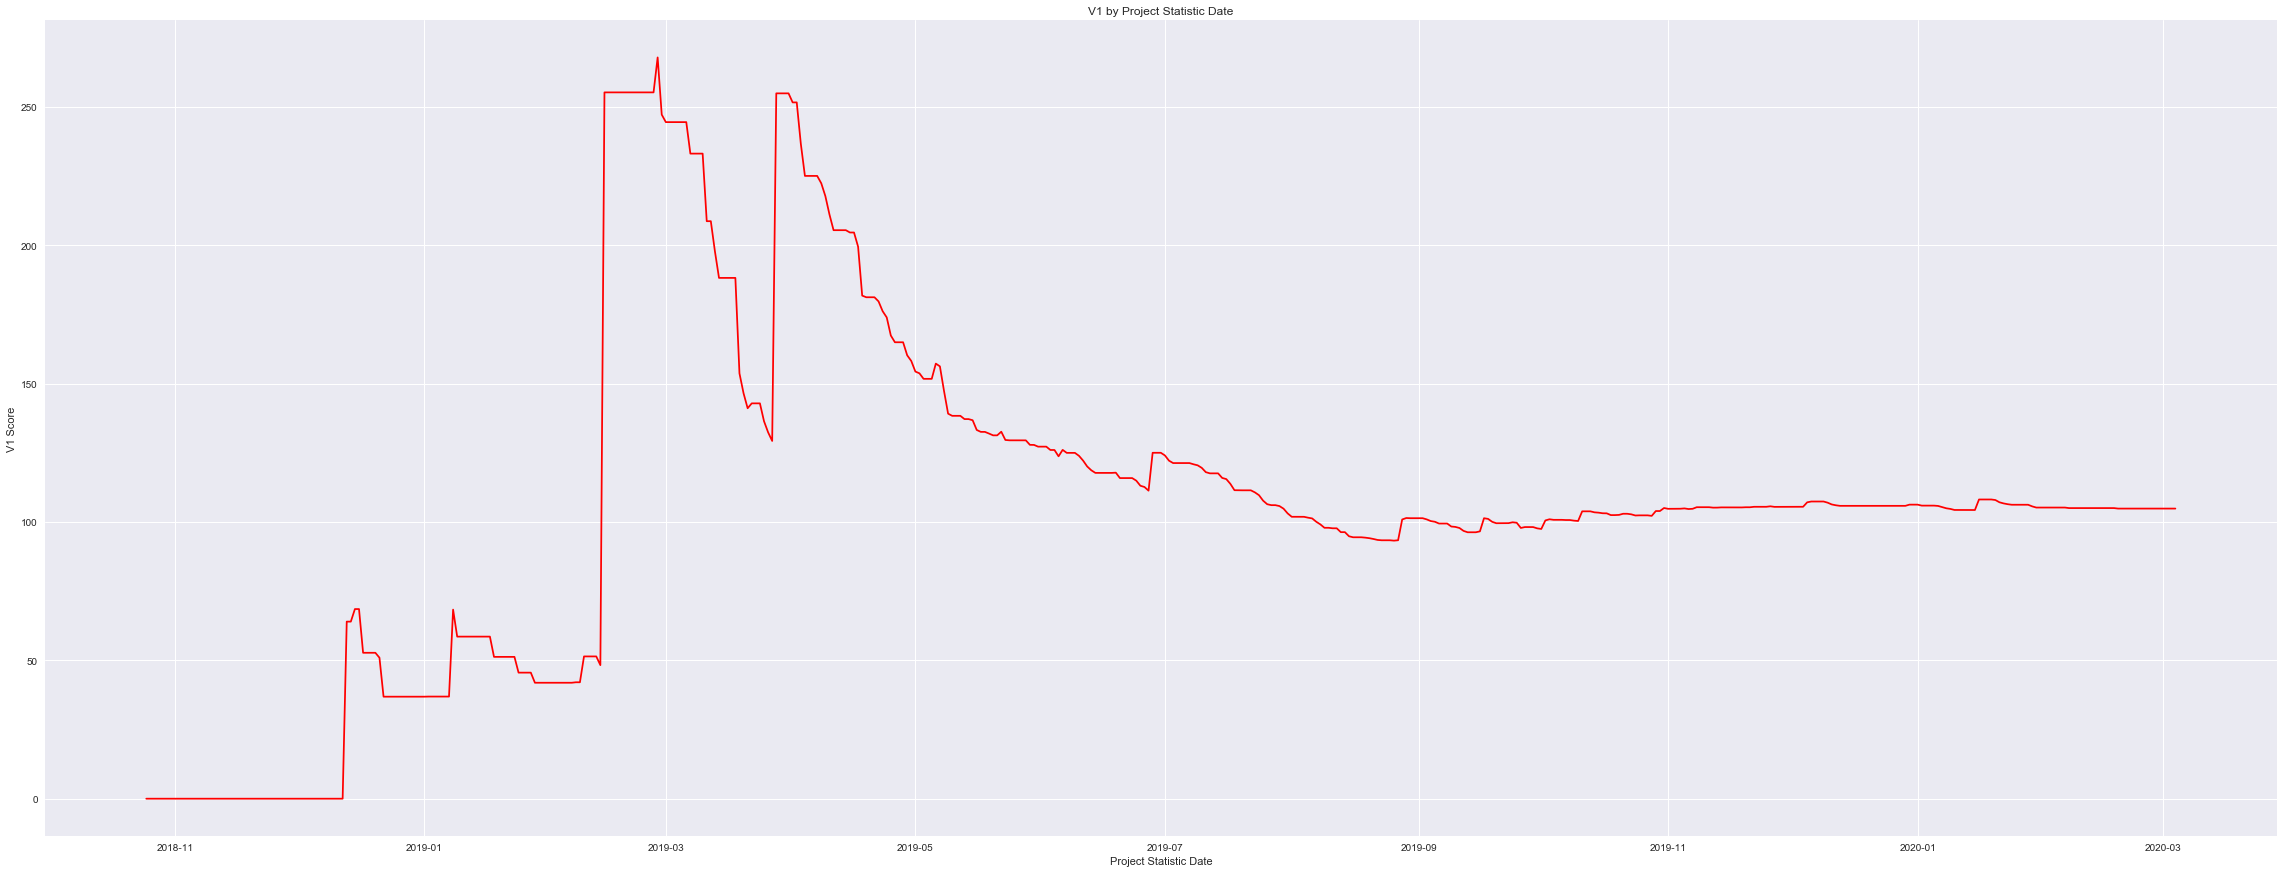

In [7]:
#Plot V1
plt.figure(1, figsize=(40, 15))
plt.plot_date(x=V1_df["Project_Statistic_Date"], y=V1_df["Project_Task_Closed_Est_Act_V1"],fmt="r-")
plt.title("V1 by Project Statistic Date")
plt.xlabel("Project Statistic Date")
plt.ylabel("V1 Score")
plt.grid(True)
plt.show()

In [8]:
V1_df['Project_Task_Closed_Est_Act_V1'].dtype

dtype('float64')

In [9]:
# Split data into testing and training
test_data_size = 12 # we want to predict final 12 days

# divide out dataset into training and test sets
V1_values = V1_df['Project_Task_Closed_Est_Act_V1'].values
train_data = V1_values[:-test_data_size]
test_data = V1_values[-test_data_size:]
print('len training data: ',len(train_data))
print('len testing data: ',len(test_data))

len training data:  447
len testing data:  12


In [10]:
# pre-processing the data: normalization 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[-0.21593249]
 [-0.21593249]
 [-0.21725515]
 [-0.21725515]
 [-0.21725515]]


In [11]:
# convert data into tensors
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12

In [12]:
'''
create_inout_sequence

accept raw input data and will return a list of tuples
1) a list of 12 ites corresponding
to the number of passengers traveling in 12 months
2) one item i.e. the number of passengers in the 12+1st month
'''
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [13]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
print(len(train_inout_seq))
train_inout_seq[:5]

435


[(tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -0.5222]),
  tensor([-0.5222])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -0.5222, -0.5222]),
  tensor([-0.4884])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -0.5222, -0.5222, -0.4884]),
  tensor([-0.4884])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -0.5222, -0.5222, -0.4884, -0.4884]),
  tensor([-0.6063])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.5222,
          -0.5222, -0.4884, -0.4884, -0.6063]),
  tensor([-0.6063]))]

## 2. Model Implementation
Implement LSTM model on Volatility Data

In [14]:
'''
Create LSTM Model

* input_size: Corresponds to the number of features in the input. 
    Though our sequence length is 12, for each month we have only 1 value
    i.e. total number of passengers, therefore the input size will be 1.
* hidden_layer_size: Specifies the number of hidden layers along with the 
    number of neurons in each layer. We will have one layer of 100 neurons.
* output_size: The number of items in the output, since we want to predict 
    the number of passengers for 1 month in the future, the output size 
    will be 1.
'''
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [15]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [16]:
'''
Training the Model

train model for 150 epochs. Loss printed every 25 epochs
'''
epochs = 200

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00001074
epoch:  26 loss: 0.00000076
epoch:  51 loss: 0.00000013
epoch:  76 loss: 0.00000056
epoch: 101 loss: 0.00000058
epoch: 126 loss: 0.00000045
epoch: 151 loss: 0.00000152
epoch: 176 loss: 0.00000086
epoch: 199 loss: 0.0000004501


## 3. Making Predictions
Predict last 12 dates

In [17]:
#filter out last 12 values of test set 
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.21593248844146729, -0.21593248844146729, -0.21593248844146729, -0.21593248844146729, -0.21593248844146729, -0.21593248844146729, -0.21593248844146729, -0.21593248844146729, -0.21593248844146729, -0.2172551453113556, -0.2172551453113556, -0.2172551453113556]


In [18]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

test_inputs[fut_pred:]

[-0.21843309700489044,
 -0.2198633998632431,
 -0.22151288390159607,
 -0.22271688282489777,
 -0.22375252842903137,
 -0.2246558517217636,
 -0.2254381775856018,
 -0.22609363496303558,
 -0.2266215682029724,
 -0.22703830897808075,
 -0.22736695408821106,
 -0.22762064635753632]

In [19]:
# Convert normalized to actual values
predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(predictions)

[[104.69778698]
 [104.50618529]
 [104.28522234]
 [104.12393605]
 [103.98520218]
 [103.86419405]
 [103.75939459]
 [103.67159029]
 [103.60086897]
 [103.54504286]
 [103.50101795]
 [103.46703363]]


In [20]:
results = V1_df.tail(12)
results['predictions']= predictions
results

/Users/l9mendoza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Project_Statistic_Date,Project_Task_Closed_Est_Act_V1,predictions
135428,2020-02-22,104.855584,104.697787
135435,2020-02-23,104.855584,104.506185
135356,2020-02-24,104.855584,104.285222
135491,2020-02-25,104.855584,104.123936
135498,2020-02-26,104.855584,103.985202
135495,2020-02-27,104.855584,103.864194
135358,2020-02-28,104.855584,103.759395
135351,2020-02-29,104.855584,103.671590
135438,2020-03-01,104.855584,103.600869
135488,2020-03-02,104.855584,103.545043


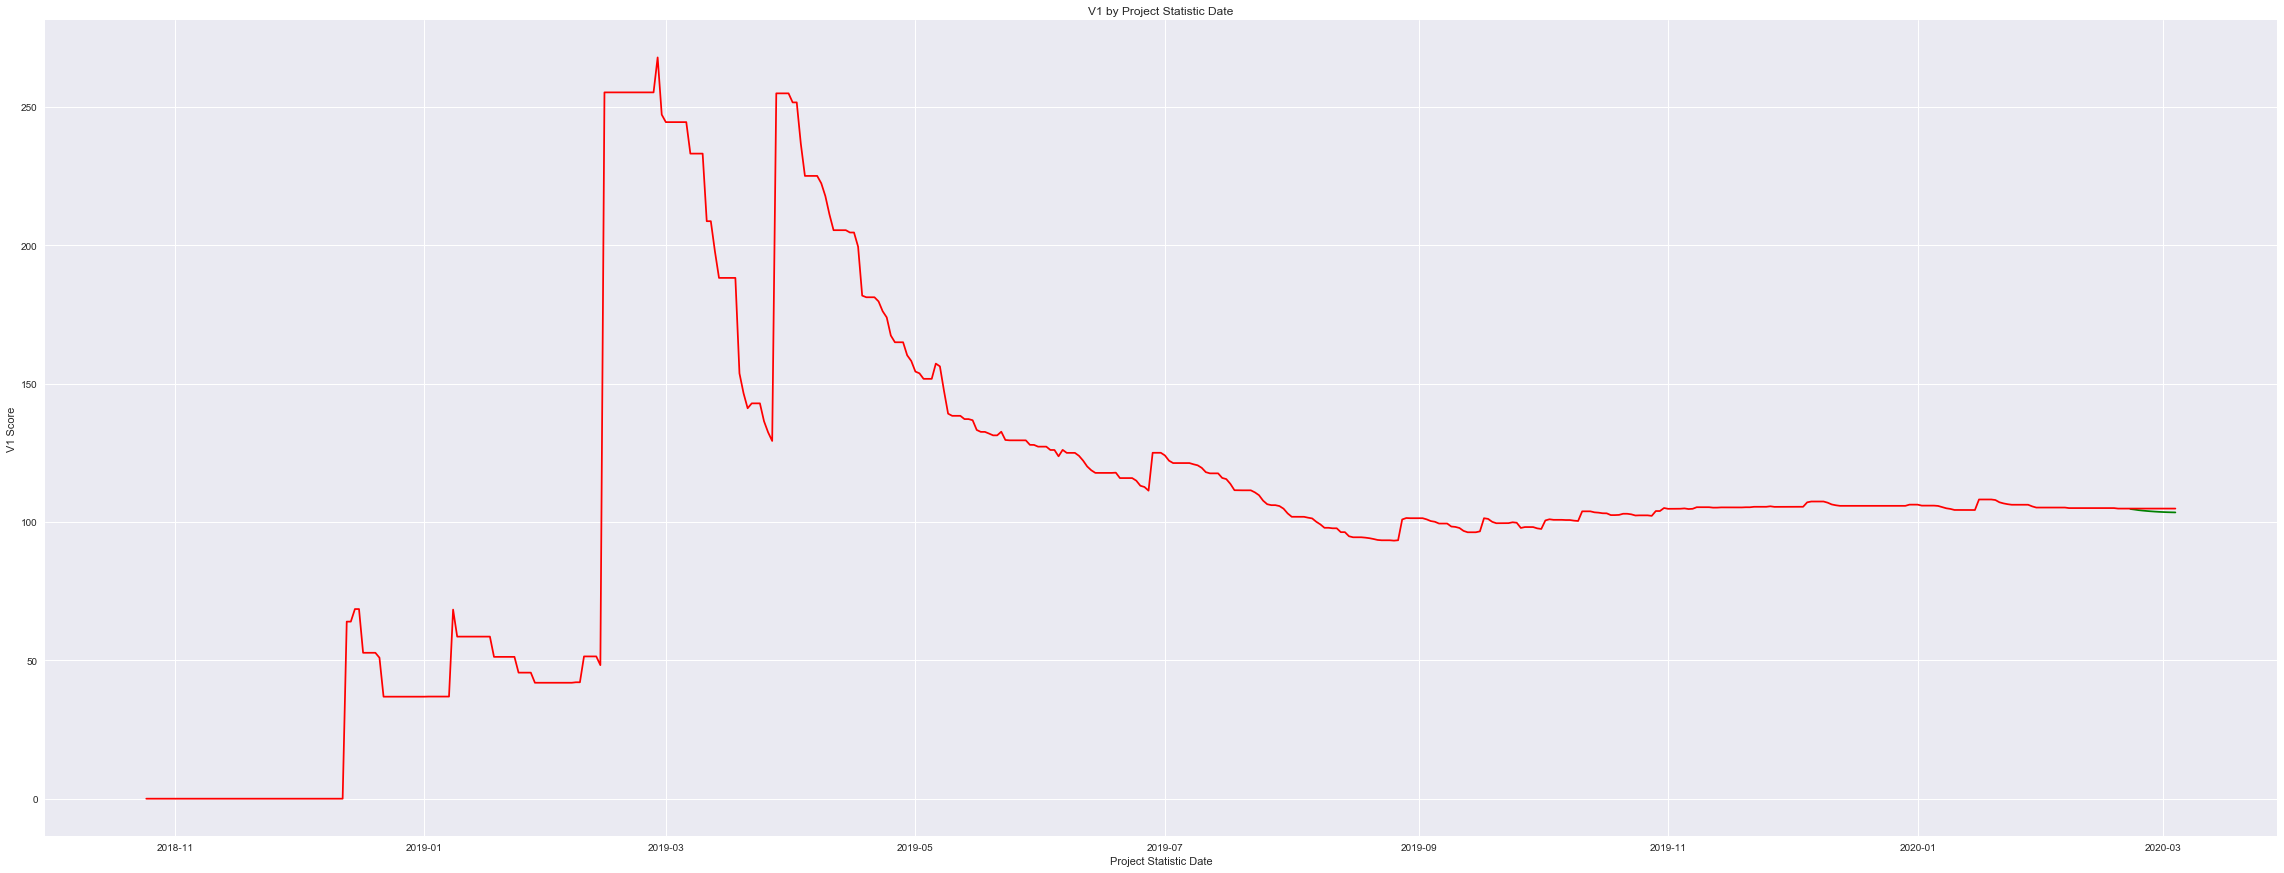

In [21]:
plt.figure(1, figsize=(40, 15))
plt.plot_date(x=results["Project_Statistic_Date"], y=results["predictions"],fmt="r-", color = 'green')
plt.plot_date(x=V1_df["Project_Statistic_Date"], y=V1_df["Project_Task_Closed_Est_Act_V1"],fmt="r-")
plt.title("V1 by Project Statistic Date")
plt.xlabel("Project Statistic Date")
plt.ylabel("V1 Score")
plt.grid(True)
plt.show()

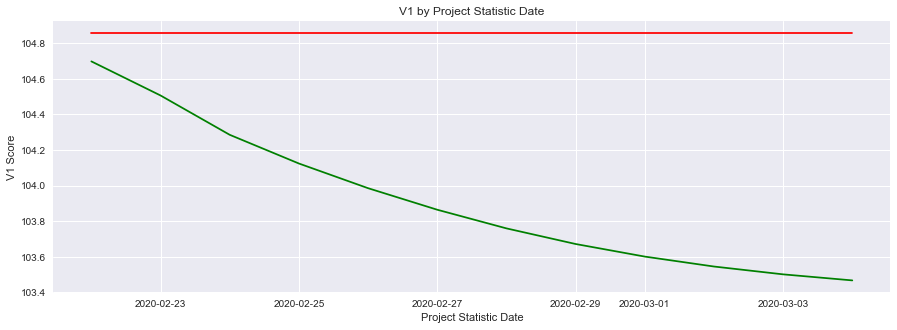

In [22]:
#Plot only test set
plt.figure(1, figsize=(15,5))
plt.plot_date(x=results["Project_Statistic_Date"], y=results["Project_Task_Closed_Est_Act_V1"],fmt="r-")
plt.plot_date(x=results["Project_Statistic_Date"], y=results["predictions"],fmt="r-", color = 'green')
plt.title("V1 by Project Statistic Date")
plt.xlabel("Project Statistic Date")
plt.ylabel("V1 Score")
plt.grid(True)
plt.show()